In [2]:
pip install download

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
%env no_proxy='a.test.com,127.0.0.1,2.2.2.2'

env: no_proxy='a.test.com,127.0.0.1,2.2.2.2'


In [4]:
from download import download

# 下载MNIST数据集
url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 92.8MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import nn
from mindspore.dataset import vision,transforms,MnistDataset
from mindspore.dataset.vision import Inter
from mindspore.common.initializer import Normal
from mindspore.train import Model

#设定运行模式为图模式，运行硬件为昇腾芯片
ms.set_context(mode=ms.GRAPH_MODE, device_target='Ascend') # Ascend, CPU, GPU

In [7]:
# 定义预处理操作的流程，整体对数据集进行处理
def datapipe(path, batch_size=32):
    image_transform = [
        vision.Resize(size=32, interpolation=Inter.LINEAR),    # Resize： 以双线性插值方式调整图像尺寸大小
        vision.Rescale(1.0 / 255.0, 0.0),                      # Rescale: 缩放图像的像素值大小，将像素值统一除255，数据类型由unit8转为float32
        vision.Normalize(mean=(0.1307,),std=(0.3081,)),       # Mormalize：将像素值归一化
        vision.HWC2CHW(),                                     # HWC2CHW：将张量格式从（height,width,channel）转换成(channel,height,width)
    ]
    label_transform = transforms.TypeCast(ms.int32)
    
    # 利用MnistDataset接口读取解压后的MNIST的训练集和测试集，并进行shuffle操作
    dataset = MnistDataset(path, shuffle=True)
    # 通过map方法对每张图片应用数据处理操作
    dataset = dataset.map(operations=image_transform, input_columns=["image"])
    # 将每个标签的数据类型转换为int32
    dataset = dataset.map(operations=label_transform, input_columns=["label"])
    # 对数据集进行分批处理；当最后一个批处理数据包含的数据条目小于batch_size时，drop_remainder表示是否将该批处理丢弃，不传递给下一个操作。默认值：False，不丢弃。
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

dataset_train = datapipe("MNIST_Data/train")
dataset_eval = datapipe("MNIST_Data/test")

Batch Size/通道数/图像长/宽： (32, 1, 32, 32)
图像的标签样式： [2 7 8 1 2 2 6 4 0 0 0 3 9 9 7 1 1 4 3 8 1 3 7 7 9 3 9 1 1 7 9 3]


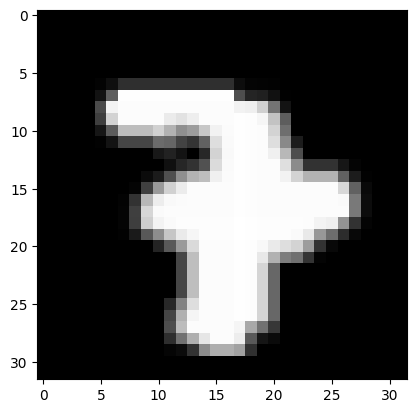

In [8]:
data_next = dataset_train.create_dict_iterator(output_numpy=True).__next__()
print('Batch Size/通道数/图像长/宽：', data_next['image'].shape)
print('图像的标签样式：', data_next['label'])

plt.figure()
plt.imshow(data_next['image'][1,...].squeeze(), cmap="gray")
plt.grid(False)
plt.show()

In [9]:
#定义模型结构，MindSpore中的模型时通过construct定义模型结构，在__init__中初始化各层的对象
class LeNet5(nn.Cell):
    """LeNet5"""

    def __init__(self, num_classes=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层，输入的通道数为num_channel,输出的通道数为6,卷积核大小为5*5
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        # 卷积层，输入的通道数为6，输出的通道数为16,卷积核大小为5*5
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # ReLU激活函数
        self.relu = nn.ReLU()
        # 池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # 多维数组展平为一维数组
        self.flatten = nn.Flatten()
        # 全连接层，输入个数为16*5*5，输出个数为120
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        # 全连接层，输入个数为120，输出个数为84
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        # 全连接层，输入个数为84，分类的个数为num_class
        self.fc3 = nn.Dense(84, num_classes, weight_init=Normal(0.02))

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# 对LeNet5进行实例化
network = LeNet5()

# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义优化器，通过model.trainable_params()方法获得模型的可训练参数，并传入学习率超参来初始化优化器
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

# 定义用于训练的train_loop函数。
def train_loop(model, dataset, loss_fn, optimizer):
    # 定义正向计算函数
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss

    # 定义微分函数，使用mindspore.value_and_grad获得微分函数grad_fn,输出loss和梯度。
    # 由于是对模型参数求导,grad_position 配置为None，传入可训练参数。
    grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

    # 定义 one-step training函数
    def train_step(data, label):
        loss, grads = grad_fn(data, label)
        optimizer(grads)
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

# 定义用于测试的test_loop函数。
def test_loop(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, dataset_train, net_loss, net_opt)
    ms.save_checkpoint(network, "./save_direct.ckpt")
    test_loop(network, dataset_eval, net_loss)
print("Done!")

Epoch 1
-------------------------------


[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:45:42.463.999 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:45:42.464.079 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:45:42.464.113 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]


loss: 2.310022  [  0/1875]
loss: 2.274877  [100/1875]
loss: 0.715073  [200/1875]
loss: 0.420944  [300/1875]
loss: 0.201703  [400/1875]
loss: 0.155780  [500/1875]
loss: 0.141726  [600/1875]
loss: 0.142582  [700/1875]
loss: 0.063522  [800/1875]
loss: 0.054072  [900/1875]
loss: 0.073684  [1000/1875]
loss: 0.140230  [1100/1875]
loss: 0.019690  [1200/1875]
loss: 0.042235  [1300/1875]
loss: 0.064062  [1400/1875]
loss: 0.006513  [1500/1875]
loss: 0.325441  [1600/1875]
loss: 0.022978  [1700/1875]
loss: 0.367078  [1800/1875]


[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:46:50.463.417 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/3728934510.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:46:50.463.504 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/3728934510.py]


Test: 
 Accuracy: 97.2%, Avg loss: 0.087453 

Epoch 2
-------------------------------


[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:46:56.366.841 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:46:56.366.905 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:46:56.366.939 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]


loss: 0.021515  [  0/1875]
loss: 0.082550  [100/1875]
loss: 0.004569  [200/1875]
loss: 0.078512  [300/1875]
loss: 0.039061  [400/1875]
loss: 0.178090  [500/1875]
loss: 0.004801  [600/1875]
loss: 0.071658  [700/1875]
loss: 0.070092  [800/1875]
loss: 0.044352  [900/1875]
loss: 0.115743  [1000/1875]
loss: 0.016467  [1100/1875]
loss: 0.002156  [1200/1875]
loss: 0.011646  [1300/1875]
loss: 0.257773  [1400/1875]
loss: 0.056542  [1500/1875]
loss: 0.016057  [1600/1875]
loss: 0.009355  [1700/1875]
loss: 0.001214  [1800/1875]
Test: 
 Accuracy: 97.8%, Avg loss: 0.071778 

Epoch 3
-------------------------------


[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:47:11.481.105 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:47:11.481.195 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]
[ERROR] CORE(1105,ffffa14f20b0,python):2024-01-30-16:47:11.481.285 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_1105/1666263637.py]


loss: 0.113496  [  0/1875]
loss: 0.247717  [100/1875]
loss: 0.007751  [200/1875]
loss: 0.003013  [300/1875]
loss: 0.075562  [400/1875]
loss: 0.036046  [500/1875]
loss: 0.137267  [600/1875]
loss: 0.002596  [700/1875]
loss: 0.180306  [800/1875]
loss: 0.132890  [900/1875]
loss: 0.018508  [1000/1875]
loss: 0.089158  [1100/1875]
loss: 0.125247  [1200/1875]
loss: 0.010648  [1300/1875]
loss: 0.034867  [1400/1875]
loss: 0.037562  [1500/1875]
loss: 0.002460  [1600/1875]
loss: 0.019139  [1700/1875]
loss: 0.019144  [1800/1875]
Test: 
 Accuracy: 98.7%, Avg loss: 0.041604 

Done!


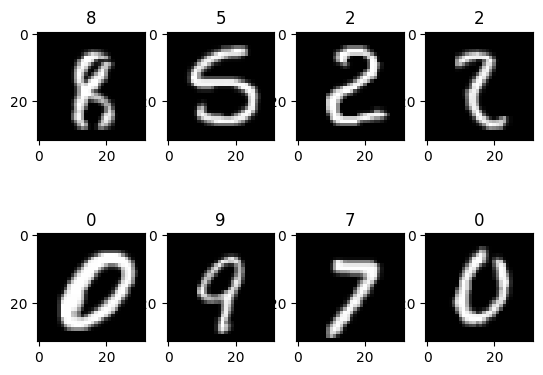

In [11]:
# 将模型参数存入parameter的字典中，采用load_checkpoint接口加载模型参数
param_dict = ms.load_checkpoint("./save_direct.ckpt")
# 重新定义一个LeNet5神经网络
net = network
# 将参数加载到网络中
ms.load_param_into_net(net, param_dict)
model = Model(net)
data_test = dataset_eval.create_dict_iterator()
data = next(data_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

# 使用函数model.predict预测image对应分类
output = model.predict(ms.Tensor(data['image']))
pred = np.argmax(output.asnumpy(), axis=1)

plt.figure()
for i in range(1, 9):
    plt.subplot(2, 4, i)
    plt.imshow(images[i-1].squeeze(), cmap="gray")
    plt.title(pred[i-1])
plt.show()